In [ ]:
import os
import pandas as pd
import os
from PIL import Image
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split

import numpy as np
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F
# !pip install datasets
from datasets import load_dataset



In [ ]:
torch.cuda.empty_cache()
import gc
gc.collect()
from pynvml import *
nvmlInit()
h = nvmlDeviceGetHandleByIndex(0)
info = nvmlDeviceGetMemoryInfo(h)
print(f'total    : {info.total}')
print(f'free     : {info.free}')
print(f'used     : {info.used}')


In [ ]:
from datasets import Dataset, load_dataset


train_ds =   Dataset.load_from_disk('/home/workstation04/GP_LiverSegmentation_MeenaMakary/deeplearning/model_data')
# test_ds = load_dataset("imagefolder", data_dir='/content/FaceShape Dataset/testing_set', split="train")
# label2idx and idx2label
label=["aNo DR", "bMild", "cModerate", "dSevere", "eProliferative DR"]
id2label = {id:label for id, label in enumerate(label)}
label2id = {label:id for id,label in id2label.items()}
# split train, val
splits = train_ds.train_test_split(test_size=0.1, shuffle=True, seed=42)
train_ds, val_ds = splits["train"], splits["test"]
print("Features", train_ds.features)
print("Train", train_ds)
print("Validation", val_ds)
# print("Test", test_ds)
# print("Num labels", len(label2id))
print("Label2Idx", label2id)
print("Label2Idx", id2label)
        

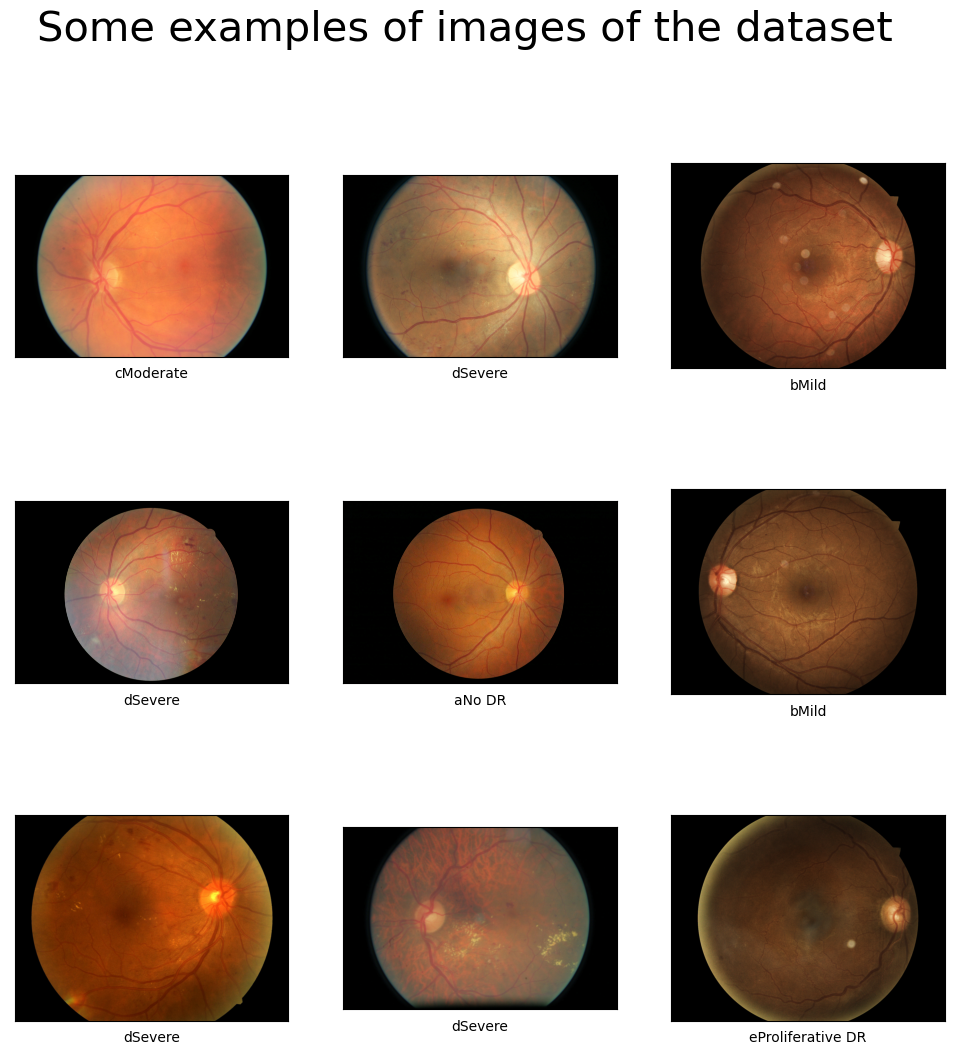

In [83]:
import cv2
import matplotlib.pyplot as plt  
from random import randint
list_idx = [randint(0, len(train_ds)) for i in range(9)]
def display_examples():
    fig = plt.figure(figsize=(12,12))
    fig.suptitle("Some examples of images of the dataset", fontsize=30)
    for i, idx in enumerate(list_idx):
        plt.subplot(3,3,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(train_ds[idx]["image"], cmap=plt.cm.binary)
        plt.xlabel(id2label[train_ds[idx]["label"]])
    plt.show()

display_examples()

In [ ]:
# !pip install transformers
from transformers import AutoFeatureExtractor
import torchvision.transforms.functional

from torchvision.transforms import (
    CenterCrop, 
    Compose, 
    Normalize, 
    RandomHorizontalFlip,
    RandomResizedCrop, 
    Resize, 
    RandomAdjustSharpness,
    ToTensor
    
)

feature_extractor = AutoFeatureExtractor.from_pretrained("microsoft/swin-tiny-patch4-window7-224")

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
_train_transforms = Compose(
        [
            RandomResizedCrop([224,224]),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize([224,224]),
            CenterCrop([224,224]),
            ToTensor(),
            normalize,
        ]
    )

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

# Set the transforms
train_ds.set_transform(train_transforms)
val_ds.set_transform(val_transforms)


In [ ]:
from torch.utils.data import DataLoader
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_dataloader = DataLoader(train_ds, collate_fn=collate_fn, batch_size=64)

In [ ]:
from transformers import SwinForImageClassification, SwinConfig

config = SwinConfig.from_pretrained(
        "microsoft/swin-tiny-patch4-window7-224",
        num_labels=len(label2id),
        label2id=label2id,
        id2label=id2label,
        finetuning_task="image-classification"
    )

model = SwinForImageClassification.from_pretrained(
    "microsoft/swin-tiny-patch4-window7-224",
    config=config,
    ignore_mismatched_sizes=True
)

In [ ]:
model

In [ ]:
from transformers import TrainingArguments, Trainer
metric_name = "accuracy"
args = TrainingArguments(
    f"faceshape",
    save_strategy="epoch",
    evaluation_strategy="epoch",                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
    learning_rate=2e-4,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=30,
    weight_decay=0.03,
    load_best_model_at_end=False,
    save_total_limit=1,
    metric_for_best_model=metric_name,
    logging_dir='logs',
    remove_unused_columns=False,
    logging_steps=15,
    eval_accumulation_steps=1,
    report_to=None
)

In [ ]:
torch.cuda.empty_cache()
import gc
gc.collect()                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

from pynvml import *
nvmlInit()
h = nvmlDeviceGetHandleByIndex(0)
info = nvmlDeviceGetMemoryInfo(h) 
print(f'total    : {info.total}')
print(f'free     : {info.free}')                                                                                                                                                    
print(f'used     : {info.used}')

In [ ]:
from datasets import load_metric
import numpy as np

metric = load_metric(metric_name)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:

os.environ["WANDB_DISABLED"] = "true"
os.environ["WANDB_MODE"] = "offline"
trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=feature_extractor,
    
)

In [ ]:

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True                                      
trainer.train()

In [ ]:
PATH = "path"
torch.save(model, PATH) 


In [84]:
    
outputs = trainer.predict(val_ds)
print(outputs.metrics)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)
labels = train_ds.features['label']

***** Running Prediction *****
  Num examples = 500
  Batch size = 64


  0%|          | 0/8 [00:00<?, ?it/s]

{'test_loss': 0.4866026043891907, 'test_accuracy': 0.838, 'test_runtime': 53.3808, 'test_samples_per_second': 9.367, 'test_steps_per_second': 0.15}


In [85]:
    
# Classification report
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.66      0.66       101
           1       0.74      0.80      0.77       113
           2       0.87      0.79      0.83        97
           3       0.97      0.96      0.96        96
           4       1.00      1.00      1.00        93

    accuracy                           0.84       500
   macro avg       0.85      0.84      0.84       500
weighted avg       0.84      0.84      0.84       500



Text(0.5, 23.52222222222222, 'Actual')

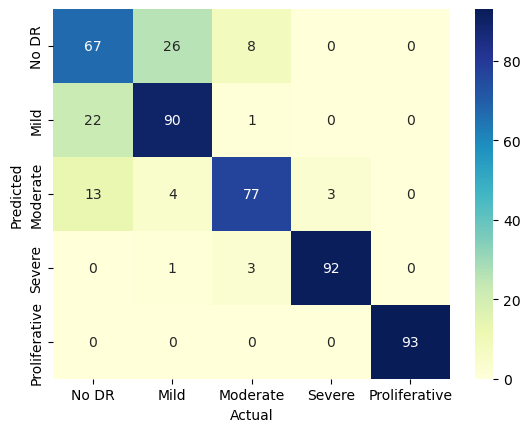

In [82]:
cm = confusion_matrix(y_true, y_pred)
import seaborn as sns
df_cm = pd.DataFrame(cm, index=['No DR', 'Mild','Moderate','Severe','Proliferative'], columns=['No DR', 'Mild','Moderate','Severe','Proliferative'])
sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
plt.ylabel("Predicted")
plt.xlabel("Actual")
# Confusion matrix

# cm = confusion_matrix(y_true, y_pred)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
# disp.plot()

In [ ]:
import shutil
shutil.copy("/content/entire_model4.pt","/content/drive/MyDrive/Assignments")
